# Cross Validation

In [32]:
import pandas as pd
import pydataset
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
tips = pydataset.data('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
X = tips[['tip', 'total_bill', 'size']]
y = tips.time

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=.2)

In [8]:
dtree = DecisionTreeClassifier(max_depth=4)

cross_val_score(dtree, X_train, y_train, cv=4).mean()

0.6922831632653061

In [15]:
from sklearn.metrics import make_scorer, precision_score

Using precision "traditionally"

In [10]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
predicted = dtree.predict(X_train)
actual = y_train

precision_score(actual, predicted, pos_label='Dinner')

0.8571428571428571

Using precision as a metric for cross validation:

In [18]:
precision_scorer = make_scorer(precision_score, pos_label='Dinner')

# decision tree w/ max_depth = 4
cross_val_score(dtree, X_train, y_train, cv=4, scoring=precision_scorer).mean()

0.7371597454477888

In [19]:
cross_val_score(DecisionTreeClassifier(max_depth=3), X_train, y_train, scoring=precision_scorer).mean()

0.7396049896049897

## Grid Search

In [39]:
from sklearn.model_selection import GridSearchCV

# keys are names of hyperparams, values are a list of values to try for that hyper parameter
params = {
    'max_depth': range(1, 11),
    'criterion': ['gini', 'entropy']
}

# cv=4 means 4-fold cross-validation, i.e. k = 4
grid = GridSearchCV(dtree, params, cv=4)
grid.fit(X_train, y_train)

grid.best_params_

{'criterion': 'entropy', 'max_depth': 3}

In [43]:
# .best_estimator_ gives us a model that is prefit with the best hyperparams
model = grid.best_estimator_
model.score(X_test, y_test)

0.6530612244897959

In [41]:
grid.best_score_

0.7387329931972789

In [42]:
results = grid.cv_results_
results

{'mean_fit_time': array([0.00745726, 0.00472051, 0.00504798, 0.00437891, 0.00305825,
        0.00504392, 0.00345784, 0.00415373, 0.00388348, 0.00434667,
        0.00298148, 0.00297493, 0.00369656, 0.00363541, 0.00335479,
        0.00385523, 0.00437647, 0.00434023, 0.00434357, 0.00538343]),
 'std_fit_time': array([0.00300004, 0.00080919, 0.00219533, 0.00082582, 0.00078912,
        0.00224456, 0.00066703, 0.0013567 , 0.00104932, 0.00086549,
        0.0002754 , 0.00013711, 0.00081302, 0.00057725, 0.00062753,
        0.00088843, 0.00082147, 0.00158639, 0.0009914 , 0.00097421]),
 'mean_score_time': array([0.00449753, 0.00206023, 0.00159401, 0.0017857 , 0.00147796,
        0.00220042, 0.00192362, 0.00224543, 0.00142628, 0.0014466 ,
        0.00143749, 0.00174928, 0.00220591, 0.00174081, 0.00172722,
        0.00204813, 0.00169319, 0.00204927, 0.00249106, 0.00190103]),
 'std_score_time': array([0.00197248, 0.0005423 , 0.0004198 , 0.00086295, 0.00046903,
        0.0007857 , 0.0002457 , 0.000532

In [36]:
import matplotlib.pyplot as plt
plt.ion()
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [50]:
results = grid.cv_results_
# Modify each parameter dictionary such that it also contains the model's average performance after cross validation
for score, p in zip(results['mean_test_score'], results['params']):
    # adding a new key to the dictionary
    p['score'] = score

# a list of dictionaries where each dictionary has the same keys can be turned into a dataframe
results['params']

pd.DataFrame(results['params'])

,criterion,max_depth,score
0,gini,1,0.733418
1,gini,2,0.733418
2,gini,3,0.718112
3,gini,4,0.702487
4,gini,5,0.620642
5,gini,6,0.676658
6,gini,7,0.661352
7,gini,8,0.671662
8,gini,9,0.651148
9,gini,10,0.656356


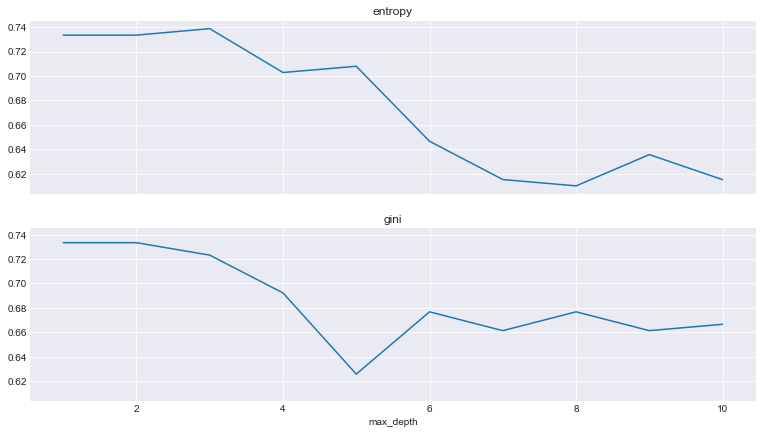

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for ax, (crit, subset) in zip(axs, pd.DataFrame(results['params']).groupby('criterion')):
    subset.set_index('max_depth').score.plot(ax=ax)
    ax.set(title=crit)

## Everything All Together

In [51]:
from sklearn.model_selection import GridSearchCV

# keys are names of hyperparams, values are a list of values to try for that hyper parameter
params = {
    'max_depth': range(1, 11),
    'criterion': ['gini', 'entropy']
}

# cv=4 means 4-fold cross-validation, i.e. k = 4
grid = GridSearchCV(dtree, params, cv=15)
grid.fit(X_train, y_train)

results = grid.cv_results_

for score, p in zip(results['mean_test_score'], results['params']):
    p['score'] = score
pd.DataFrame(results['params'])

,criterion,max_depth,score
0,gini,1,0.733333
1,gini,2,0.723077
2,gini,3,0.712821
3,gini,4,0.707692
4,gini,5,0.707692
5,gini,6,0.666667
6,gini,7,0.687179
7,gini,8,0.666667
8,gini,9,0.666667
9,gini,10,0.676923
